# Import

In [1]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

## Add configuration file

In [19]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../../PlotFunction/lineplot/")
sys.path.append("../../PlotFunction/config/")

In [20]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

# Read data

In [5]:
news_df = pd.read_csv("../../../Preprocessing/data/AgNews/master.csv", index_col=0)

In [6]:
with open("../../../Preprocessing/data/AgNews/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [7]:
vector_dims = config["vectorize"]["doc2vec"]["dims"]
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]

In [8]:
label = news_df["class"].to_numpy()

# Data shaping

In [14]:
threshold = 0.95

In [ ]:
dist_path = "../../../Clustering/data/AgNews/doc2vec/GMM/dist/"

In [23]:
# データ型定義
low_confirm_counts = {
    covariance_type: {
        vector_dim: {model_num: pd.DataFrame for model_num in range(model_nums)}
        for vector_dim in vector_dims
    }
    for covariance_type in covariance_types
}

# データ取得
for covariance_type in tqdm(covariance_types):
    for vector_dim in vector_dims:
        for model_num in range(model_nums):
            dist = np.load(
                f"{dist_path}{vector_dim}/{covariance_type}/{model_num}.npy",
            )
            low_confirm_counts[covariance_type][vector_dim][model_num] = len(
                news_df[dist.min(axis=1) > sps.chi2.ppf(q=threshold, df=vector_dim)]
            )

100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


In [32]:
describes = {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
for covariance_type in tqdm(covariance_types):
    df = pd.DataFrame(low_confirm_counts[covariance_type])
    describes[covariance_type], describe_keys = get_describe(df, axis=0)

100%|██████████| 4/4 [00:00<00:00, 264.57it/s]


In [33]:
data = {describe_key: pd.DataFrame() for describe_key in describe_keys}
for describe_key in describe_keys:
    _data = {
        covariance_type: describes[covariance_type][describe_key]
        for covariance_type in covariance_types
    }
    data[describe_key] = pd.concat(_data, axis=1)

In [40]:
data["std"]

,spherical,diag,tied,full
2,3204.830056,42.713547,1154.941571,2124.860450
4,126.490148,577.985642,52.156055,1569.258476
6,0.827682,3.032582,4.352434,3.438959
8,0.000000,1.165106,0.182574,2.490441
10,0.000000,0.000000,1.082781,2.377094
20,0.000000,0.000000,2.192201,15.135442
40,0.000000,0.000000,18.872500,51.088935
80,0.000000,0.000000,18.998155,74.893365
160,0.000000,0.000000,50.295049,139.515834


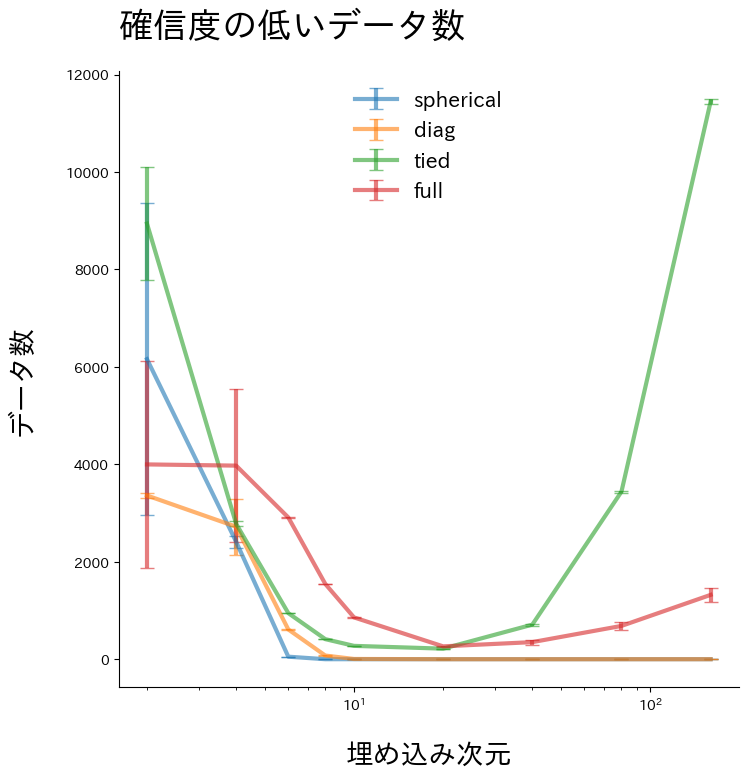

In [42]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
# fig_path = f"../../data/figure/AgNews/doc2vec/GMM/stats/{stats_val}.pdf"
ax.set_xscale('log')
line_plot_error_1(
    data["mean"],
    error_low=data["std"],
    error_upper=data["std"],
    fig=fig,
    ax=ax,
    layout=layout,
    title="確信度の低いデータ数",
    xlabel="埋め込み次元",
    ylabel="データ数",
#     path=fig_path,
)
